# Set up environment

In [23]:
import cv2                                # state of the art computer vision algorithms library
import numpy as np                        # fundamental package for scientific computing
import matplotlib.pyplot as plt           # 2D plotting library producing publication quality figures
from mpl_toolkits.mplot3d import Axes3D
import pyrealsense2 as rs                 # Intel RealSense cross-platform open-source API
import math
import time
print("Environment Ready")
from numba import cuda
import imutils

Environment Ready


In [24]:
pipe = rs.pipeline()
cfg = rs.config()
# cfg.enable_device_from_file("../object_detection.bag")
# profile = pipe.start(cfg)

width = 640
height = 480
fps = 30


cfg.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
cfg.enable_stream(rs.stream.color, width, height, rs.format.bgr8, fps)

profile = pipe.start(cfg)
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
print("Depth Scale is: " , depth_scale)

Depth Scale is:  0.0010000000474974513


In [77]:
def getMask(color_image):
    greenLower = (29, 60, 20)
    greenUpper = (90, 255, 255)
    frame = color_image
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask

In [ ]:
def getMask(color_image):
    greenLower = (29, 60, 20)
    greenUpper = (90, 255, 255)
    frame = color_image
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask

In [ ]:
def getRedMask(color_image):
    greenLower = (29, 60, 20)
    greenUpper = (90, 255, 255)
    frame = color_image
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # construct a mask for the color "green", then perform
    # a series of dilations and erosions to remove any small
    # blobs left in the mask
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)
    return mask

In [28]:
for i in range(50):
    frames = pipe.wait_for_frames()
align = rs.align(rs.stream.color)
frames = align.process(frames)
color_frame = frames.get_color_frame()
aligned_depth_frame = frames.get_depth_frame()


depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(frames.get_color_frame().get_data())

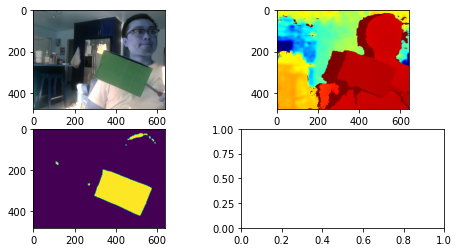

In [29]:
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
maskImage= getMask(color_image)
maskRed=getRedMask(color_image)


# show 3 images
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(color_image)
ax[0,1].imshow(depth_colormap)
ax[1,0].imshow(maskImage)

RuntimeError: Error occured during execution of the processing block! See the log for more info

In [45]:
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 2)

depth_to_disparity = rs.disparity_transform(True)
disparity_to_depth = rs.disparity_transform(False)
spatial = rs.spatial_filter()
spatial.set_option(rs.option.filter_magnitude, 5)
spatial.set_option(rs.option.filter_smooth_alpha, 1)
spatial.set_option(rs.option.filter_smooth_delta, 50)

temporal = rs.temporal_filter()

hole_filling = rs.hole_filling_filter()

frame = aligned_depth_frame
frame = decimation.process(frame)
frame = depth_to_disparity.process(frame)
frame = spatial.process(frame)
frame = temporal.process(frame)
frame = disparity_to_depth.process(frame)
frame = hole_filling.process(frame)

In [46]:
depth_image_new = np.asanyarray(frame.get_data())
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image_new, alpha=0.03), cv2.COLORMAP_JET)

In [47]:
depth_image_new.shape

(240, 320)

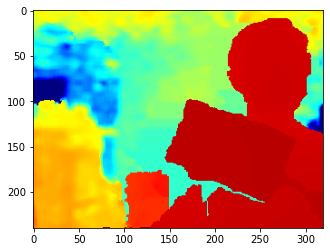

In [48]:
plt.imshow(depth_colormap)

In [220]:
depth = depth_image_new.astype(np.float32)
distance = depth * depth_scale

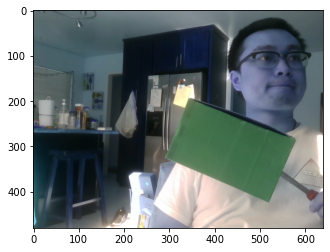

In [53]:
decimation = rs.decimation_filter()
decimation.set_option(rs.option.filter_magnitude, 4)
colored_frame = frames.get_color_frame()
new_color_frame = decimation.process(colored_frame)
new_color_image = np.asanyarray(new_color_frame.get_data())
plt.imshow(new_color_image)

In [75]:
color_image=cv2.resize(color_image,(320,240),interpolation = cv2.INTER_AREA)

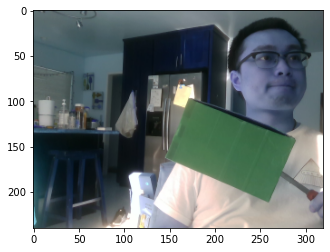

In [76]:
plt.imshow(color_image)

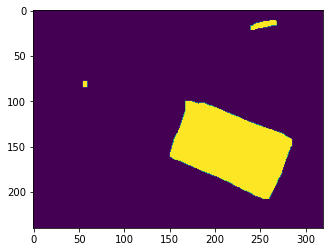

In [79]:
plt.imshow(getMask(color_image))

In [121]:
mask=getMask(color_image)

In [128]:
@cuda.jit
def gpu_boolconverter_helper(input_image, result_image):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    if(input_image[y_val,x_val]):
        result_image[y_val,x_val] = 1
    else:
        result_image[y_val,x_val] = 0
        
def gpu_boolmask_filter(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.zeros((240, 320), dtype = np.bool)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_boolconverter_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

In [129]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [130]:
np.max(gpu_boolmask_filter(mask))

True

In [171]:
@cuda.jit
def gpu_mask_filter_helper(input_image, result_image):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    
    temp_counter = 0
    if(y_val >=5 and x_val>=5 and y_val<=234 and x_val!=314):
        temp_counter = (input_image[y_val-5, x_val-5]+input_image[y_val-5, x_val-4]+input_image[y_val-5, x_val-3]+input_image[y_val-5, x_val-2]+input_image[y_val-5, x_val-1]+input_image[y_val-5, x_val]
                       +input_image[y_val-5, x_val+5]+input_image[y_val-5, x_val+4]+input_image[y_val-5, x_val+3]+input_image[y_val-5, x_val+2]+input_image[y_val-5, x_val+1]
                       +input_image[y_val-4, x_val+5]+input_image[y_val-3, x_val+5]+input_image[y_val-2, x_val+5]+input_image[y_val-1, x_val+5]+input_image[y_val, x_val+5]+input_image[y_val+1, x_val+5]
                       +input_image[y_val+2, x_val+5]+input_image[y_val+3, x_val+5]+input_image[y_val+4, x_val+5]+input_image[y_val+5, x_val+5]+input_image[y_val+5, x_val+4]+input_image[y_val+5, x_val+3]
                    +input_image[y_val+5, x_val+2]+input_image[y_val+5, x_val+1]+input_image[y_val+5, x_val]+input_image[y_val+5, x_val-1]+input_image[y_val+5, x_val-2]+input_image[y_val+5, x_val-3]+input_image[y_val+5, x_val-4]+input_image[y_val+5, x_val-5]+input_image[y_val+4, x_val-5]
                    +input_image[y_val+3, x_val-5]+input_image[y_val+2, x_val-5]+input_image[y_val+1, x_val-5]+input_image[y_val, x_val-5]+input_image[y_val-1, x_val-5]+input_image[y_val-2, x_val-5]+input_image[y_val-3, x_val-5]+input_image[y_val-4, x_val-5])
        if(temp_counter<=21):
            result_image[y_val,x_val] = 0
        else:
            result_image[y_val,x_val] = input_image[y_val,x_val]
#     debug_mat[y_val,x_val]= temp_counter
            
       
        

def gpu_mask_filter(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    
#     debug_mat = np.zeros((240, 320), dtype = np.float32)
#     debug_mat_device = cuda.to_device(debug_mat)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_mask_filter_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

In [172]:
mask_2 = gpu_boolmask_filter(getMask(color_image))

In [179]:
temp_filted_mask = gpu_mask_filter(mask_2)

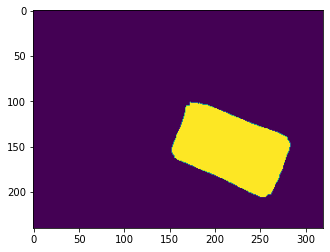

In [180]:
plt.imshow(temp_filted_mask)

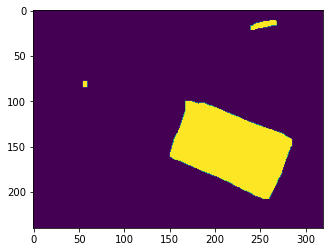

In [178]:
plt.imshow(mask_2)

In [213]:
@cuda.jit
def gpu_set_noise_negative_helper(depth_map, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    if(depth_map[y_val, x_val] < 0.1):
        result[y_val, x_val] = -999.0
    else:
        result[y_val, x_val] = depth_map[y_val, x_val]
def gpu_set_noise_negative(depth_map):
    depth_map_device = cuda.to_device(depth_map)
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_set_noise_negative_helper[blocks_per_grid, threads_per_block](depth_map_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result



@cuda.jit
def gpu_worker_ver_1(in_bound_non_zero_y, in_bound_non_zero_x,out_bound_non_zero_y, out_bound_non_zero_x, distance_map, result):
    in_index = cuda.blockIdx.x
    out_index = cuda.threadIdx.x
    
    in_y = in_bound_non_zero_y[in_index]
    in_x = in_bound_non_zero_x[in_index]
    out_y = out_bound_non_zero_y[out_index]
    out_x = out_bound_non_zero_x[out_index]
    
    in_depth = distance_map[in_y, in_x]
    out_depth = distance_map[out_y, out_x]
    
    if(in_depth > 0.05):
        if(out_depth > 0.05):
            if(abs(in_depth - out_depth) < 0.05):
                result[in_index, out_index] = (out_y-in_y)**2 + (out_x-in_x)**2
            else:
                result[in_index, out_index] = 9999.0
        else:
            result[in_index, out_index] = 9999.0
    else:
        result[in_index, out_index] = 9999.0
        
    
    
    
    
def gpu_get_depth_matrix_ver1(in_bound_non_zero_tuple, out_bound_non_zero_tuple, distance_map):

    
    in_bound_non_zero_y = np.ascontiguousarray(in_bound_non_zero_tuple[0])
    in_bound_non_zero_x = np.ascontiguousarray(in_bound_non_zero_tuple[1])
    out_bound_non_zero_y = np.ascontiguousarray(out_bound_non_zero_tuple[0])
    out_bound_non_zero_x = np.ascontiguousarray(out_bound_non_zero_tuple[1])

    in_bound_non_zero_y_device = cuda.to_device(in_bound_non_zero_y)
    in_bound_non_zero_x_device = cuda.to_device(in_bound_non_zero_x)
    out_bound_non_zero_y_device = cuda.to_device(out_bound_non_zero_y)
    out_bound_non_zero_x_device = cuda.to_device(out_bound_non_zero_x)

    distance_map_device = cuda.to_device(distance_map)
    
    num_of_in = len(in_bound_non_zero_tuple[0])
    num_of_out = len(out_bound_non_zero_tuple[0])

    
    gpu_result = np.zeros((num_of_in, num_of_out), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = num_of_in
    threads_per_block = num_of_out
    try:
        gpu_worker_ver_1[blocks_per_grid, threads_per_block](in_bound_non_zero_y_device, in_bound_non_zero_x_device, out_bound_non_zero_y_device, out_bound_non_zero_x_device, distance_map_device, gpu_result_device)
        cuda.synchronize()
        gpu_result = gpu_result_device.copy_to_host()
    except:
        np.save('in_bound_non_zero_tuple', in_bound_non_zero_tuple)
        np.save('out_bound_non_zero_tuple', out_bound_non_zero_tuple)
        np.save('distance_map', distance_map)
        print("error!")
    return gpu_result



@cuda.jit
def gpu_pad_helper(input_image, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
#     idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if(y_val!=0 and x_val!=0 and y_val!=239 and x_val!=319):
        if(result[y_val, x_val] == 0):
            if(input_image[y_val-1, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val-1, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val-1, x_val+1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val, x_val+1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val-1]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val]):
                result[y_val, x_val] = 1
            elif(input_image[y_val+1, x_val+1]):
                result[y_val, x_val] = 1

def gpu_padding(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_pad_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_padding_device(maskImage, iterator_number):
    maskImage_device = cuda.to_device(maskImage)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    
    for i in range(iterator_number):
        gpu_result = np.zeros((240, 320), dtype = np.float32)
        gpu_result_device = cuda.to_device(gpu_result)
        gpu_pad_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
        maskImage_device = gpu_result_device
    cuda.synchronize()
    return gpu_result_device





@cuda.jit
def gpu_pad_inverse_helper(input_image, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
#     idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if(y_val!=0 and x_val!=0 and y_val!=239 and x_val!=319):
        if(result[y_val, x_val] == 1):
            if(input_image[y_val-1, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val-1, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val-1, x_val+1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val, x_val+1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val-1]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val]==0):
                result[y_val, x_val] = 0
            elif(input_image[y_val+1, x_val+1]==0):
                result[y_val, x_val] = 0

def gpu_padding_inverse(maskImage):
    maskImage_device = cuda.to_device(maskImage)
    gpu_result = np.ones((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_pad_inverse_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_padding_inverse_device(maskImage, iterator_number):
    maskImage_device = cuda.to_device(maskImage)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    
    for i in range(iterator_number):
        gpu_result = np.ones((240, 320), dtype = np.float32)
        gpu_result_device = cuda.to_device(gpu_result)
        gpu_pad_inverse_helper[blocks_per_grid, threads_per_block](maskImage_device, gpu_result_device)
        maskImage_device = gpu_result_device
    cuda.synchronize()
    return gpu_result_device


@cuda.jit
def gpu_minus_helper(input_image_minuend, input_image_subtracter, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    result[y_val, x_val] = input_image_minuend[y_val, x_val] - input_image_subtracter[y_val, x_val]
    

def gpu_minus(input_image_minuend, input_image_subtracter):
    input_image_minuend_device = cuda.to_device(input_image_minuend)
    input_image_subtracter_device = cuda.to_device(input_image_subtracter)
    
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_minus_helper[blocks_per_grid, threads_per_block](input_image_minuend_device, input_image_subtracter_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result

def gpu_minus_device(input_image_minuend_device, input_image_subtracter_device):
    gpu_result = np.zeros((240, 320), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_minus_helper[blocks_per_grid, threads_per_block](input_image_minuend_device, input_image_subtracter_device, gpu_result_device)
    cuda.synchronize()
    return gpu_result_device


@cuda.jit
def gpu_stack_helper(input_image_one, input_image_two, result):
    y_val = (cuda.blockIdx.x)//320*12+cuda.threadIdx.x
    x_val = (cuda.blockIdx.x)%320
    
    if(input_image_two[y_val, x_val] > 0):
        result[y_val, x_val, 0] = 255
        result[y_val, x_val, 1] = 255
        result[y_val, x_val, 2] = 255
    else:
        result[y_val, x_val, 0] = input_image_one[y_val, x_val,0]
        result[y_val, x_val, 1] = input_image_one[y_val, x_val,1]
        result[y_val, x_val, 2] = input_image_one[y_val, x_val,2]
def gpu_stack(input_image_one, input_image_two):
    input_image_one_device = cuda.to_device(input_image_one)
    input_image_two_device = cuda.to_device(input_image_two)
    
    gpu_result = np.zeros((240, 320, 3), dtype = np.float32)
    gpu_result_device = cuda.to_device(gpu_result)
    
    blocks_per_grid = 6400
    threads_per_block = 12
    gpu_stack_helper[blocks_per_grid, threads_per_block](input_image_one_device, input_image_two_device, gpu_result_device)
    cuda.synchronize()
    gpu_result = gpu_result_device.copy_to_host()
    return gpu_result



in bound and out bound

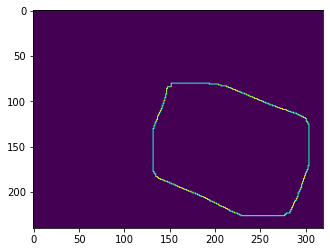

In [196]:
pad_8 = temp_filted_mask
pad_8 = gpu_padding_device(pad_8, 20)
pad_9 = pad_8
pad_9 = gpu_padding_device(pad_9, 1)

out_bound_line_result = gpu_minus_device(pad_9, pad_8)
out_bound_line_result_img = out_bound_line_result.copy_to_host()
plt.imshow(out_bound_line_result_img*255)

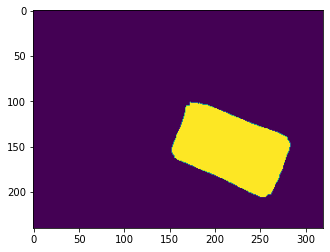

In [197]:
plt.imshow(temp_filted_mask)

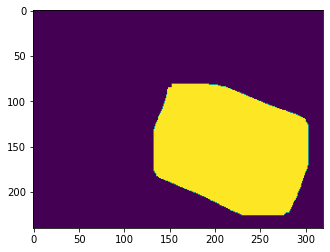

In [198]:
plt.imshow(pad_8)

In [199]:
image_to_display = gpu_stack(color_image, out_bound_line_result_img).astype(np.uint8)

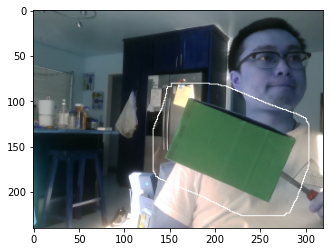

In [200]:
plt.imshow(image_to_display)

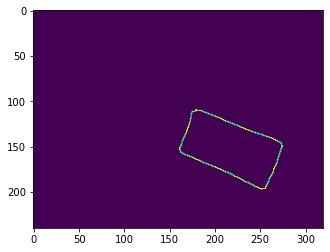

In [208]:
img1 = gpu_padding_inverse_device(temp_filted_mask, 6)
img2 = gpu_padding_inverse_device(img1, 1)
in_bound_line_result_img = gpu_minus_device(img1, img2).copy_to_host()
plt.imshow(in_bound_line_result_img)

In [211]:
image_to_display = gpu_stack(depth_colormap, out_bound_line_result_img+in_bound_line_result_img).astype(np.uint8)

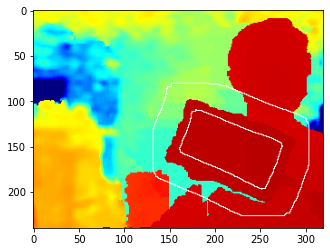

In [212]:
plt.imshow(image_to_display)

In [215]:
in_bound_non_zero_tuple = np.nonzero(in_bound_line_result_img)
out_bound_non_zero_tuple = np.nonzero(out_bound_line_result_img)

In [216]:
num_of_in = len(in_bound_non_zero_tuple[0])
num_of_out = len(out_bound_non_zero_tuple[0])

In [217]:
num_of_in

403

In [218]:
num_of_out

636

In [223]:
# if(num_of_in > 0 and num_of_out > 0):
        
distance_matrix = gpu_get_depth_matrix_ver1(in_bound_non_zero_tuple, out_bound_non_zero_tuple, distance)

indices_min_val = np.where(depth_matrix <=50 + np.min(depth_matrix))


In [222]:

min_value = depth_matrix[indices_min_val[0][0], indices_min_val[1][0]]
in_val_y = in_bound_non_zero_tuple[0][indices_min_val[0][0]]
in_val_x = in_bound_non_zero_tuple[1][indices_min_val[0][0]]

out_val_y = out_bound_non_zero_tuple[0][indices_min_val[1][0]]
out_val_x = out_bound_non_zero_tuple[1][indices_min_val[1][0]]

temp = min_value
temp_in_y = in_val_y
temp_in_x = in_val_x
temp_out_y = out_val_y
temp_out_x = out_val_x

1157.0

In [224]:
indices_min_val

(array([311, 317, 317, 317, 317, 321, 326, 326, 326, 326, 334, 334, 334]),
 array([429, 429, 433, 442, 452, 429, 429, 433, 442, 452, 429, 442, 452]))

In [227]:
for i in range(len(indices_min_val[0])):
    in_val_y = in_bound_non_zero_tuple[0][indices_min_val[0][i]]
    in_val_x = in_bound_non_zero_tuple[1][indices_min_val[0][i]]

    out_val_y = out_bound_non_zero_tuple[0][indices_min_val[1][i]]
    out_val_x = out_bound_non_zero_tuple[1][indices_min_val[1][i]]

    temp_in_y = in_val_y
    temp_in_x = in_val_x
    temp_out_y = out_val_y
    temp_out_x = out_val_x
    image_to_display = cv2.circle(image_to_display, (temp_in_x,temp_in_y), radius=3, color=(255, 0, 0), thickness=3)
    image_to_display = cv2.circle(image_to_display, (temp_out_x,temp_out_y), radius=3, color=(0, 255, 0), thickness=3)

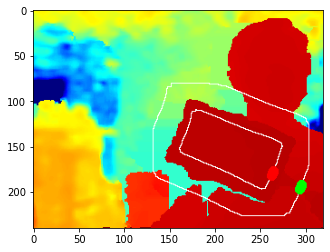

In [228]:
plt.imshow(image_to_display)